# Skip-gram Word2Vec

In this notebook, I'll lead you through using PyTorch to implement the [Word2Vec algorithm](https://en.wikipedia.org/wiki/Word2vec) using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of Word2Vec from Chris McCormick 
* [First Word2Vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [Neural Information Processing Systems, paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for Word2Vec also from Mikolov et al.

---
## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of word classes to analyze; one for each word in a vocabulary. Trying to one-hot encode these words is massively inefficient because most values in a one-hot vector will be set to zero. So, the matrix multiplication that happens in between a one-hot input vector and a first, hidden layer will result in mostly zero-valued hidden outputs.

<img src='assets/one_hot_encoding.png' width=50%>

To solve this problem and greatly increase the efficiency of our networks, we use what are called **embeddings**. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

<img src='assets/lookup_matrix.png' width=50%>

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='assets/tokenize_lookup.png' width=50%>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.

---
## Word2Vec

The Word2Vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words.

<img src="assets/context_drink.png" width=40%>

Words that show up in similar **contexts**, such as "coffee", "tea", and "water" will have vectors near each other. Different words will be further away from one another, and relationships can be represented by distance in vector space.

<img src="assets/vector_distance.png" width=40%>


There are two architectures for implementing Word2Vec:
>* CBOW (Continuous Bag-Of-Words) and 
* Skip-gram

<img src="assets/word2vec_architectures.png" width=60%>

In this implementation, we'll be using the **skip-gram architecture** because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

---
## Loading Data

Next, we'll ask you to load in data and place it in the `data` directory

1. Load the [text8 dataset](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip); a file of cleaned up *Wikipedia article text* from Matt Mahoney. 
2. Place that data in the `data` folder in the home directory.
3. Then you can extract it and delete the archive, zip file to save storage space.

After following these steps, you should have one file in your data directory: `data/text8`.

In [1]:
# read in the extracted text file      
with open('data/text8') as f:
    text = f.read()

# print out the first 100 characters
print(text[:100])

 anarchism originated as a term of abuse first used against early working class radicals including t


In [2]:
text[:500]

' anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philoso'

## Pre-processing

Here I'm fixing up the text to make training easier. This comes from the `utils.py` file. The `preprocess` function does a few things:
>* It converts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. 
* It removes all words that show up five or *fewer* times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. 
* It returns a list of words in the text.

This may take a few seconds to run, since our text file is quite large. If you want to write your own functions for this stuff, go for it!

In [3]:
import utils

# get list of words
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [4]:
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 16680599
Unique words: 63641


### Dictionaries

Next, I'm creating two dictionaries to convert words to integers and back again (integers to words). This is again done with a function in the `utils.py` file. `create_lookup_tables` takes in a list of words in a text and returns two dictionaries.
>* The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1, and so on. 

Once we have our dictionaries, the words are converted to integers and stored in the list `int_words`.

In [5]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580]


## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

$$ P(0) = 1 - \sqrt{\frac{1*10^{-5}}{1*10^6/16*10^6}} = 0.98735 $$

I'm going to leave this up to you as an exercise. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

In [8]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
print(list(word_counts.items())[0])  # dictionary of int_words, how many times they appear

total_count = len(int_words)
discard_probability = {}
for int_word, count in word_counts.items():
    discard_probability[int_word] = 1 - (np.sqrt(threshold / (count / total_count)))

# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = []
for int_word in int_words:
    if discard_probability[int_word] < random.random():
        train_words.append(int_word)

print(train_words[:30])

(5233, 303)
[3080, 10571, 133, 27349, 15067, 58112, 854, 10712, 1324, 454, 371, 539, 686, 7088, 5233, 248, 44611, 2877, 792, 1134, 8983, 6437, 4186, 5233, 1818, 4860, 6753, 7573, 11064, 7088]


In [10]:
print("Total words in text:       {}".format(len(words)))
print("Total words for training :  {}".format(len(train_words)))

Total words in text:       16680599
Total words for training :  4627093


## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to define a surrounding _context_ and grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $[ 1: C ]$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you chose a random number of words to from the window.

Say, we have an input and we're interested in the idx=2 token, `741`: 
```
[5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712]
```

For `R=2`, `get_target` should return a list of four values:
```
[5233, 58, 10571, 27349]
```

In [11]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    # implement this function
    R = np.random.randint(1, window_size+1)
    
    if idx - R > 0:
        start_idx = idx - R
    else:
        start_idx = 0
    
    stop_idx = idx + R
    
    return words[start_idx:idx] + words[idx+1:stop_idx+1]

In [12]:
# test your code!

# run this cell multiple times to check for random window selection
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5 # word index of interest

target = get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)  # you should get some indices around the idx

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [2, 3, 4, 6, 7, 8]


In [15]:
idx=0 # word index of interest
target = get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)  # you should get some indices around the idx

Target:  [1, 2, 3, 4]


In [14]:
idx=9 # word index of interest
target = get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)  # you should get some indices around the idx

Target:  [6, 7, 8]


### Generating Batches 

Here's a generator function that returns batches of input and target data for our model, using the `get_target` function from above. The idea is that it grabs `batch_size` words from a words list. Then for each of those batches, it gets the target words in a window.

In [16]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

In [17]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]
y
 [1, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 2]


In [19]:
for x, y in get_batches(int_text, batch_size=4, window_size=5):
    print('x\n', x)
    print('y\n', y)
    print()

x
 [0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]
y
 [1, 2, 0, 2, 3, 0, 1, 3, 0, 1, 2]

x
 [4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7]
y
 [5, 6, 4, 6, 7, 4, 5, 7, 4, 5, 6]

x
 [8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11]
y
 [9, 10, 8, 10, 11, 8, 9, 11, 8, 9, 10]

x
 [12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15]
y
 [13, 14, 15, 12, 14, 15, 12, 13, 15, 12, 13, 14]

x
 [16, 16, 16, 17, 17, 17, 18, 18, 18, 19]
y
 [17, 18, 19, 16, 18, 19, 16, 17, 19, 18]



## Building the graph

Below is an approximate diagram of the general structure of our network.
<img src="assets/skip_gram_arch.png" width=60%>

>* The input words are passed in as batches of input word tokens. 
* This will go into a hidden layer of linear units (our embedding layer). 
* Then, finally into a softmax output layer. 

We'll use the softmax layer to make a prediction about the context words by sampling, as usual.

The idea here is to train the embedding layer weight matrix to find efficient representations for our words. We can discard the softmax layer because we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in _other_ networks we build using this dataset.

---
## Validation

Here, I'm creating a function that will help us observe our model as it learns. We're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them using the cosine similarity: 

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$


We can encode the validation words as vectors $\vec{a}$ using the embedding table, then calculate the similarity with each word vector $\vec{b}$ in the embedding table. With the similarities, we can print out the validation words and words in our embedding table semantically similar to those words. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [20]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

## SkipGram model

Define and train the SkipGram model. 
> You'll need to define an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) and a final, softmax output layer.

An Embedding layer takes in a number of inputs, importantly:
* **num_embeddings** – the size of the dictionary of embeddings, or how many rows you'll want in the embedding weight matrix
* **embedding_dim** – the size of each embedding vector; the embedding dimension

In [21]:
import torch
from torch import nn
import torch.optim as optim

In [22]:
class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        # complete this SkipGram model
        self.embed = nn.Embedding(n_vocab, n_embed)
        self.output = nn.Linear(n_embed, n_vocab)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        
        # define the forward behavior
        x = self.embed(x)
        x = self.output(x)
        x = self.log_softmax(x)
        
        return x

### Training

Below is our training loop, and I recommend that you train on GPU, if available.

**Note that, because we applied a softmax function to our model output, we are using NLLLoss** as opposed to cross entropy. This is because Softmax  in combination with NLLLoss = CrossEntropy loss .

In [23]:
# check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

embedding_dim = 300 # 300 # you can change, if you want
batch_size = 256 # 512

model = SkipGram(len(vocab_to_int), embedding_dim).to(device)
criterion = nn.NLLLoss()

# Using GTX 1060 with 6 GiB GPU memory and 512 batch size,
# Adam optimizer faces out of memory with 300 and 200 embedding dimensions.
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Using GTX 1060 with 6 GiB GPU memory and 512 batch size,
# SGD optimizer faces out of memory with 300, 200 and 100 embedding dimensions.
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print_every = 500
steps = 0
epochs = 5

# train for some number of epochs
for e in range(epochs):
    
    # get input and target batches
    for inputs, targets in get_batches(train_words, batch_size):
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)
        
        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:                  
            # getting examples and similarities      
            valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
            _, closest_idxs = valid_similarities.topk(6) # topk highest similarities
            
            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...")

states | nadh, lvor, lunel, kalmyk, attire
at | misconduct, theremin, stillborn, katz, backbone
they | pebbles, lead, abaci, impart, tighter
more | presidential, simplicity, sebring, rations, supremum
where | bluesy, mitzvah, efe, anemometers, day
when | twiddle, nguema, fusion, lagoons, waterhouse
an | benedictine, lumo, scratching, order, kershaw
not | aorta, morrison, terminator, elixir, areas
existence | clash, leander, stored, rainey, nigeria
test | choreographed, mouvement, uniformly, omniscience, exploits
versions | aphrodite, zetalisp, bahar, thaddeus, piece
liberal | reith, texts, galeazzo, hillbillies, deceitful
gold | blurry, patricia, ligands, overruled, banknotes
engine | observational, kfor, choice, quantifying, cornwell
event | emphases, keyer, acosta, retreats, anodes
shows | lhs, meine, flurry, extravagance, establishing
...
on | presume, hallam, battlestar, skirt, bristles
about | simulacrum, mimic, distinctions, pachomius, comers
the | festive, chappell, hygiene, att

not | student, aorta, trivially, points, terminator
which | congresses, optics, starfish, ladder, hellenistic
states | nadh, lvor, kalmyk, menelik, deficit
an | lumo, benedictine, kershaw, scratching, order
had | thermidor, oneself, detachment, ejaculate, partisans
world | older, histogram, lema, mcduck, antonin
state | allahabad, mt, cabinet, burgundians, carl
five | three, eight, yusuf, two, ordain
heavy | mnemosyne, rocket, educating, ravens, bru
accepted | allies, dukedom, syed, unveils, enya
hold | delays, dessert, anyone, contrary, vega
active | counters, centering, edouard, exonerated, backgammon
test | mouvement, uniformly, fnl, choreographed, pavilion
dr | blount, caidin, eixample, estrangement, bando
defense | albigensian, amoral, bourdieu, perpignan, courier
gold | tin, ligands, blurry, hahn, overruled
...
three | five, spiderweb, technology, diatribe, disillusioned
eight | nine, five, tithes, dano, placename
and | ensues, petrovich, commuter, iskcon, spied
american | disgui

after | demands, livingston, mui, negotiations, bessel
th | prakash, baum, zero, eleventh, holland
five | three, two, zero, eight, six
for | statism, division, no, hamdan, permissible
most | around, dormitories, europeans, gilpin, rural
first | deferment, was, exclusionary, font, enrique
no | blinds, encapsulating, humbled, lucent, comrades
its | blinding, maps, championship, olwen, democrat
magazine | stoppard, implausible, linspire, mandelbrot, skier
derived | wider, dddddd, tranquil, biblical, sealand
liberal | reith, invalidating, deceitful, texts, galeazzo
square | accommodates, mti, fanlisting, disposition, winged
mathematics | pap, find, unifies, tann, osi
nobel | bryant, prize, diderot, codebreaking, gassendi
report | methods, dubnium, kilgore, pushkin, cricinfo
recorded | caen, strokes, vexed, putnam, hobbits
...
one | zero, four, two, seven, nine
there | of, lignin, artifacts, circ, ohms
been | nebuchadrezzar, odilo, tracts, comrade, grosbeak
first | deferment, font, exclusio

called | urinating, is, classical, an, stags
also | increasing, recent, com, for, abundant
was | he, his, had, continued, s
between | persson, inner, yaqub, tenets, western
were | after, ships, areas, soon, several
will | if, we, weeks, so, can
all | wto, reasonable, pair, every, for
by | the, bundys, a, as, inadequately
experience | cornucopia, kihei, merkatz, job, goldsworthy
prince | adrian, ascended, ockham, kingdom, lav
bill | balla, christiansen, president, extrajudicial, unconstitutional
http | org, www, com, sites, html
alternative | gaugamela, tokoeka, procedure, rosicrucians, grubb
mathematics | mathematician, geometry, theorem, physics, unifies
freedom | willson, crucis, freedoms, recipients, intercourse
active | centering, reflect, suppressive, presbyterians, redundancy
...
of | in, the, and, one, countries
there | are, is, ohms, be, circ
can | properties, nor, mean, say, just
all | wto, as, from, just, pair
so | if, that, wish, cause, occurs
will | if, we, weeks, something

seven | two, one, three, nine, five
as | the, and, a, is, in
he | his, him, who, himself, was
been | still, tracts, banteng, were, has
no | we, give, will, they, jansenism
that | not, is, of, it, the
other | are, some, including, different, these
five | zero, two, six, three, eight
grand | brunswick, headquarters, uther, duchy, hayastan
recorded | band, song, records, strokes, album
pressure | temperature, heat, combustion, valve, evaporating
operating | microsoft, code, apple, software, implemented
road | elbe, bike, river, roads, connects
bill | christiansen, actress, nine, fillmore, jimmy
event | tess, crofts, losing, mcmaster, bootp
applied | such, subsystem, flatland, making, specialised
...
into | so, the, oxen, divided, sintering
b | d, c, e, k, eight
these | some, other, often, different, within
use | used, andean, holder, or, often
by | of, and, the, during, in
all | if, where, just, list, remaining
eight | one, six, five, nine, three
his | he, himself, she, him, son
woman | c

up | leave, into, leaving, out, them
during | after, time, summer, occurred, broke
no | to, that, our, does, can
war | fought, nazi, soviet, campaign, wwii
but | not, with, apparently, handsets, to
have | other, been, such, had, some
had | was, been, he, were, himself
may | be, can, either, do, cannot
hold | must, tutorials, pseudocode, embroidery, automatically
frac | right, left, x, sum, mathbf
magazine | published, news, monthly, magazines, titled
mean | merleau, foreknowledge, perfectly, average, proper
alternative | spiky, wendish, gaugamela, public, romanisation
smith | frank, john, george, robert, routledge
bible | testament, biblical, jesus, translations, hebrew
applied | disciplines, types, approach, example, is
...
by | the, of, an, which, in
seven | three, one, nine, five, eight
four | three, one, zero, five, eight
the | of, a, to, in, s
was | soon, he, had, until, after
such | these, existence, uses, exist, often
six | one, five, seven, eight, three
when | again, after, bef

who | he, their, others, they, participate
nine | one, three, seven, two, four
system | systems, operating, control, branch, based
from | of, the, also, as, and
first | was, after, former, one, second
five | seven, two, zero, six, four
about | million, mi, per, news, articles
would | did, to, so, had, tried
san | francisco, california, los, diego, mexico
governor | president, senate, appointed, elected, provincial
marriage | married, marry, daughter, marriages, wife
applications | software, computer, windows, environments, macintosh
shown | television, longed, supposedly, revealed, purple
behind | straight, fingernails, cocalus, swiftly, troops
institute | university, technology, studies, research, professor
accepted | reports, deposed, remain, disputed, was
...
no | separate, never, certain, that, may
he | his, reputation, him, who, himself
history | th, century, see, of, asia
called | other, or, a, by, which
were | sold, their, many, manufacturers, destroyed
for | a, an, using, devel

eight | one, two, three, four, six
war | forces, battle, troops, allied, occupation
i | you, want, my, tell, got
in | the, major, zero, from, of
will | if, must, be, play, every
as | the, a, with, often, and
are | or, can, is, usually, all
about | has, large, coordinates, mi, brazil
issue | lawsuit, worthington, issues, chaired, cosmopolitanism
taking | broke, worst, nidal, shortfalls, devolved
rise | rising, kaolin, sprung, peaks, cimmerians
notes | crossword, press, external, lessons, routledge
ice | hockey, thick, glacial, snow, freezing
joseph | charles, politician, pianist, poet, novelist
file | files, format, formats, text, compression
egypt | syria, egyptian, ancient, arab, cairo
...
during | began, continued, after, era, cold
were | their, had, was, survived, later
was | had, became, last, the, time
at | where, home, the, opening, near
one | nine, two, eight, three, seven
see | references, links, list, external, http
this | that, a, the, is, as
or | is, typically, usually, comm

he | his, was, him, father, himself
no | according, throne, was, princess, brother
on | into, its, zero, behind, october
the | of, in, which, by, and
a | to, as, an, of, in
are | or, form, some, similar, examples
war | battle, allied, army, german, fought
years | year, male, female, age, deaths
issue | agenda, political, opinion, established, contend
quite | probably, ironic, different, contrast, osteichthyes
hold | all, obtains, holds, must, consider
road | roads, street, bridge, highway, bridges
grand | knights, lorraine, louis, garter, kuznetsova
joseph | john, robert, thomas, smith, laureate
writers | novelists, poets, fiction, births, deaths
shows | show, television, aired, episode, sketch
...
where | rightarrow, frac, left, mathbf, speed
first | seven, one, until, eight, nine
american | nine, singer, one, eight, born
with | s, of, double, the, three
new | york, jersey, books, virginia, university
five | three, seven, eight, six, zero
this | of, that, language, common, an
so | all

if | be, we, someone, must, let
a | is, the, and, are, or
there | or, is, other, are, such
often | usually, are, such, be, as
one | seven, nine, six, eight, four
zero | five, two, three, four, one
which | on, by, a, several, name
see | list, history, external, website, article
additional | hebrew, talmud, prayers, prayer, include
writers | novelists, fiction, authors, poets, atheists
mathematics | mathematical, physics, astronomy, philosophy, professor
operations | personnel, security, operation, forces, headquarters
joseph | press, d, poet, jr, geologist
dr | d, university, tracy, psychiatrist, institute
grand | tuscany, lorraine, knights, louis, duchess
recorded | recordings, sessions, recording, albums, album
...
world | of, largest, europe, history, economies
a | the, to, and, of, small
in | and, of, the, international, was
has | and, due, in, within, the
are | and, a, other, includes, known
states | united, u, countries, state, kingdom
of | the, and, in, main, one
over | zero, six

history | references, links, external, see, encyclopedia
four | two, three, zero, seven, one
people | natives, americans, activists, civil, outside
known | see, probably, theologian, various, most
be | can, if, that, simple, cannot
into | divided, the, up, through, enter
up | into, off, ground, out, drove
only | to, required, allow, reduced, larger
assembly | legislative, seats, bicameral, council, elections
instance | cases, normally, combination, allows, cygnus
shows | show, television, monty, vanunu, sketch
award | awards, best, medal, awarded, nomination
something | sure, false, thing, helpful, sanctify
square | triangle, cubic, metres, mile, tower
road | roads, street, bridge, bridges, trains
freedom | conscience, freedoms, socialism, rights, liberalism
...
where | at, f, near, the, left
often | typically, usually, especially, distinctive, used
only | to, there, the, once, where
nine | one, three, seven, two, eight
many | these, numerous, groups, other, include
and | with, in, the

at | three, six, four, five, one
system | systems, control, allows, structure, using
this | is, of, forms, concept, the
he | him, his, she, friend, wife
there | minimal, are, is, be, if
one | eight, nine, five, seven, three
other | are, contain, different, can, which
also | list, external, from, links, see
know | we, things, don, think, how
active | stabilizes, nutrient, participates, enzyme, adp
question | questions, answer, answered, problem, why
freedom | discrimination, rights, freedoms, racism, libertarian
operating | unix, linux, windows, dos, os
additional | unsigned, cb, permitting, fourth, lha
hold | members, scrip, they, reject, consider
units | unit, si, metre, nist, measurement
...
american | actress, nine, actor, seven, singer
may | be, often, treated, are, or
first | year, century, date, early, in
for | a, zero, contributions, use, only
it | if, that, be, way, come
at | four, six, was, three, of
used | use, using, uses, or, obsolete
which | the, of, between, and, principa

the | of, in, as, and, for
can | allows, necessary, respond, higher, application
into | near, off, journey, portions, quickly
are | there, include, traditional, prayer, these
such | including, notable, and, as, authors
where | at, in, enrolled, he, university
they | who, their, them, up, we
there | are, is, all, that, though
egypt | egyptian, mesopotamia, cairo, arab, syria
marriage | marriages, divorce, married, marry, daughter
units | unit, si, per, kilogram, metre
paris | des, mie, aise, les, notre
consists | consist, thick, consisting, comprises, provides
proposed | proposal, proposals, commission, reconsidered, rejected
pre | civilization, historically, columbian, mayan, teotihuacan
joseph | louis, jr, pierre, poet, son
...
from | north, in, central, southeastern, and
in | the, also, after, was, three
eight | six, four, one, nine, seven
can | or, is, allows, consists, be
their | who, to, they, were, counterparts
no | that, there, sylvan, only, not
have | these, been, other, many, 

such | environments, other, many, are, used
s | of, zero, eight, seven, two
b | d, politician, poet, writer, mathematician
his | he, him, himself, father, died
who | whom, father, murdered, men, but
known | name, modern, derived, later, by
may | on, or, is, there, mg
state | legislature, department, federal, states, government
existence | belief, universe, beings, transcendent, philosophical
liberal | liberals, conservative, labour, social, liberalism
freedom | freedoms, conscience, obligation, rights, moral
road | roads, motorway, route, street, buses
mean | arithmetic, descriptive, denote, outranks, evidently
discovered | discoverer, discovery, jakob, ancestor, chemist
smith | journalist, ceo, jr, terry, samantha
articles | article, links, encyclopedia, editorial, magazine
...
first | third, place, was, two, april
four | five, two, one, six, three
seven | two, three, one, four, six
three | one, two, six, zero, seven
in | and, the, of, from, s
states | united, countries, us, nations, 

four | one, eight, three, seven, five
th | rd, nd, century, st, west
where | quad, qquad, mathbf, turns, if
called | the, or, with, of, a
may | diagnosis, that, without, cases, be
would | ever, might, asked, did, be
such | defined, used, some, use, known
his | him, he, father, had, who
powers | representative, vested, unicameral, constitutional, executive
san | francisco, california, angeles, los, jose
active | participates, uag, terminal, methionine, attend
question | questions, discourse, assumptions, theory, explanation
bible | testament, torah, tanakh, hebrew, chabad
running | run, ran, longest, linux, runs
creation | creationism, creationist, science, evolutionary, deism
recorded | recording, record, song, elvis, albums
...
would | might, could, accept, be, hopefully
while | smaller, however, either, more, reject
he | his, him, childhood, friend, father
but | that, these, result, and, they
if | x, y, satisfies, inverse, therefore
new | york, jersey, links, vermont, lexington
of | 

s | eight, six, nine, two, d
this | is, be, which, the, can
time | last, season, next, mvp, at
than | less, more, higher, slightly, greater
up | out, train, leave, into, starts
who | whom, him, claimed, leader, asked
not | does, that, do, be, unlike
of | the, in, by, is, and
egypt | egyptian, cairo, mesopotamia, egyptians, arab
cost | expensive, costs, market, budget, savings
smith | robert, jr, david, john, thomas
lived | settled, period, levant, babylonian, captivity
woman | she, her, male, mother, daughter
recorded | recording, song, anatomically, earliest, songs
question | asked, questions, answer, answered, sends
pope | papal, pius, bishops, xiii, catholic
...
six | one, eight, five, four, three
b | d, six, one, eight, seven
about | surveyed, reported, kilometer, sq, largest
which | into, connecting, instead, its, however
may | or, use, each, commonly, occur
five | zero, one, six, three, seven
states | united, u, state, presidents, nations
if | can, axiom, be, therefore, suppose
o

GPU Utilization

```
$ while sleep 0.2; do nvidia-smi --query-gpu=name,index,temperature.gpu,utilization.gpu,utilization.memory,memory.total,memory.free,memory.used --format=csv,noheader; done

GeForce GTX 1060, 0, 76, 100 %, 74 %, 6078 MiB, 817 MiB, 5261 MiB
GeForce GTX 1060, 0, 75, 100 %, 75 %, 6078 MiB, 817 MiB, 5261 MiB
GeForce GTX 1060, 0, 76, 100 %, 77 %, 6078 MiB, 817 MiB, 5261 MiB
GeForce GTX 1060, 0, 76, 100 %, 72 %, 6078 MiB, 817 MiB, 5261 MiB
GeForce GTX 1060, 0, 76, 100 %, 86 %, 6078 MiB, 817 MiB, 5261 MiB
GeForce GTX 1060, 0, 76, 100 %, 65 %, 6078 MiB, 817 MiB, 5261 MiB
GeForce GTX 1060, 0, 76, 100 %, 76 %, 6078 MiB, 817 MiB, 5261 MiB
GeForce GTX 1060, 0, 76, 100 %, 66 %, 6078 MiB, 816 MiB, 5262 MiB
GeForce GTX 1060, 0, 76, 100 %, 75 %, 6078 MiB, 817 MiB, 5261 MiB
GeForce GTX 1060, 0, 76, 100 %, 70 %, 6078 MiB, 817 MiB, 5261 MiB
GeForce GTX 1060, 0, 76, 100 %, 72 %, 6078 MiB, 817 MiB, 5261 MiB
GeForce GTX 1060, 0, 76, 100 %, 70 %, 6078 MiB, 817 MiB, 5261 MiB
GeForce GTX 1060, 0, 76, 100 %, 68 %, 6078 MiB, 817 MiB, 5261 MiB
GeForce GTX 1060, 0, 76, 100 %, 80 %, 6078 MiB, 817 MiB, 5261 MiB
GeForce GTX 1060, 0, 76, 100 %, 68 %, 6078 MiB, 817 MiB, 5261 MiB
GeForce GTX 1060, 0, 76, 100 %, 76 %, 6078 MiB, 817 MiB, 5261 MiB
GeForce GTX 1060, 0, 76, 100 %, 74 %, 6078 MiB, 817 MiB, 5261 MiB
GeForce GTX 1060, 0, 76, 100 %, 73 %, 6078 MiB, 817 MiB, 5261 MiB
GeForce GTX 1060, 0, 76, 100 %, 68 %, 6078 MiB, 817 MiB, 5261 MiB
GeForce GTX 1060, 0, 76, 100 %, 75 %, 6078 MiB, 817 MiB, 5261 MiB
```

## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [25]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.embed.weight.to('cpu').data.numpy()

In [26]:
viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

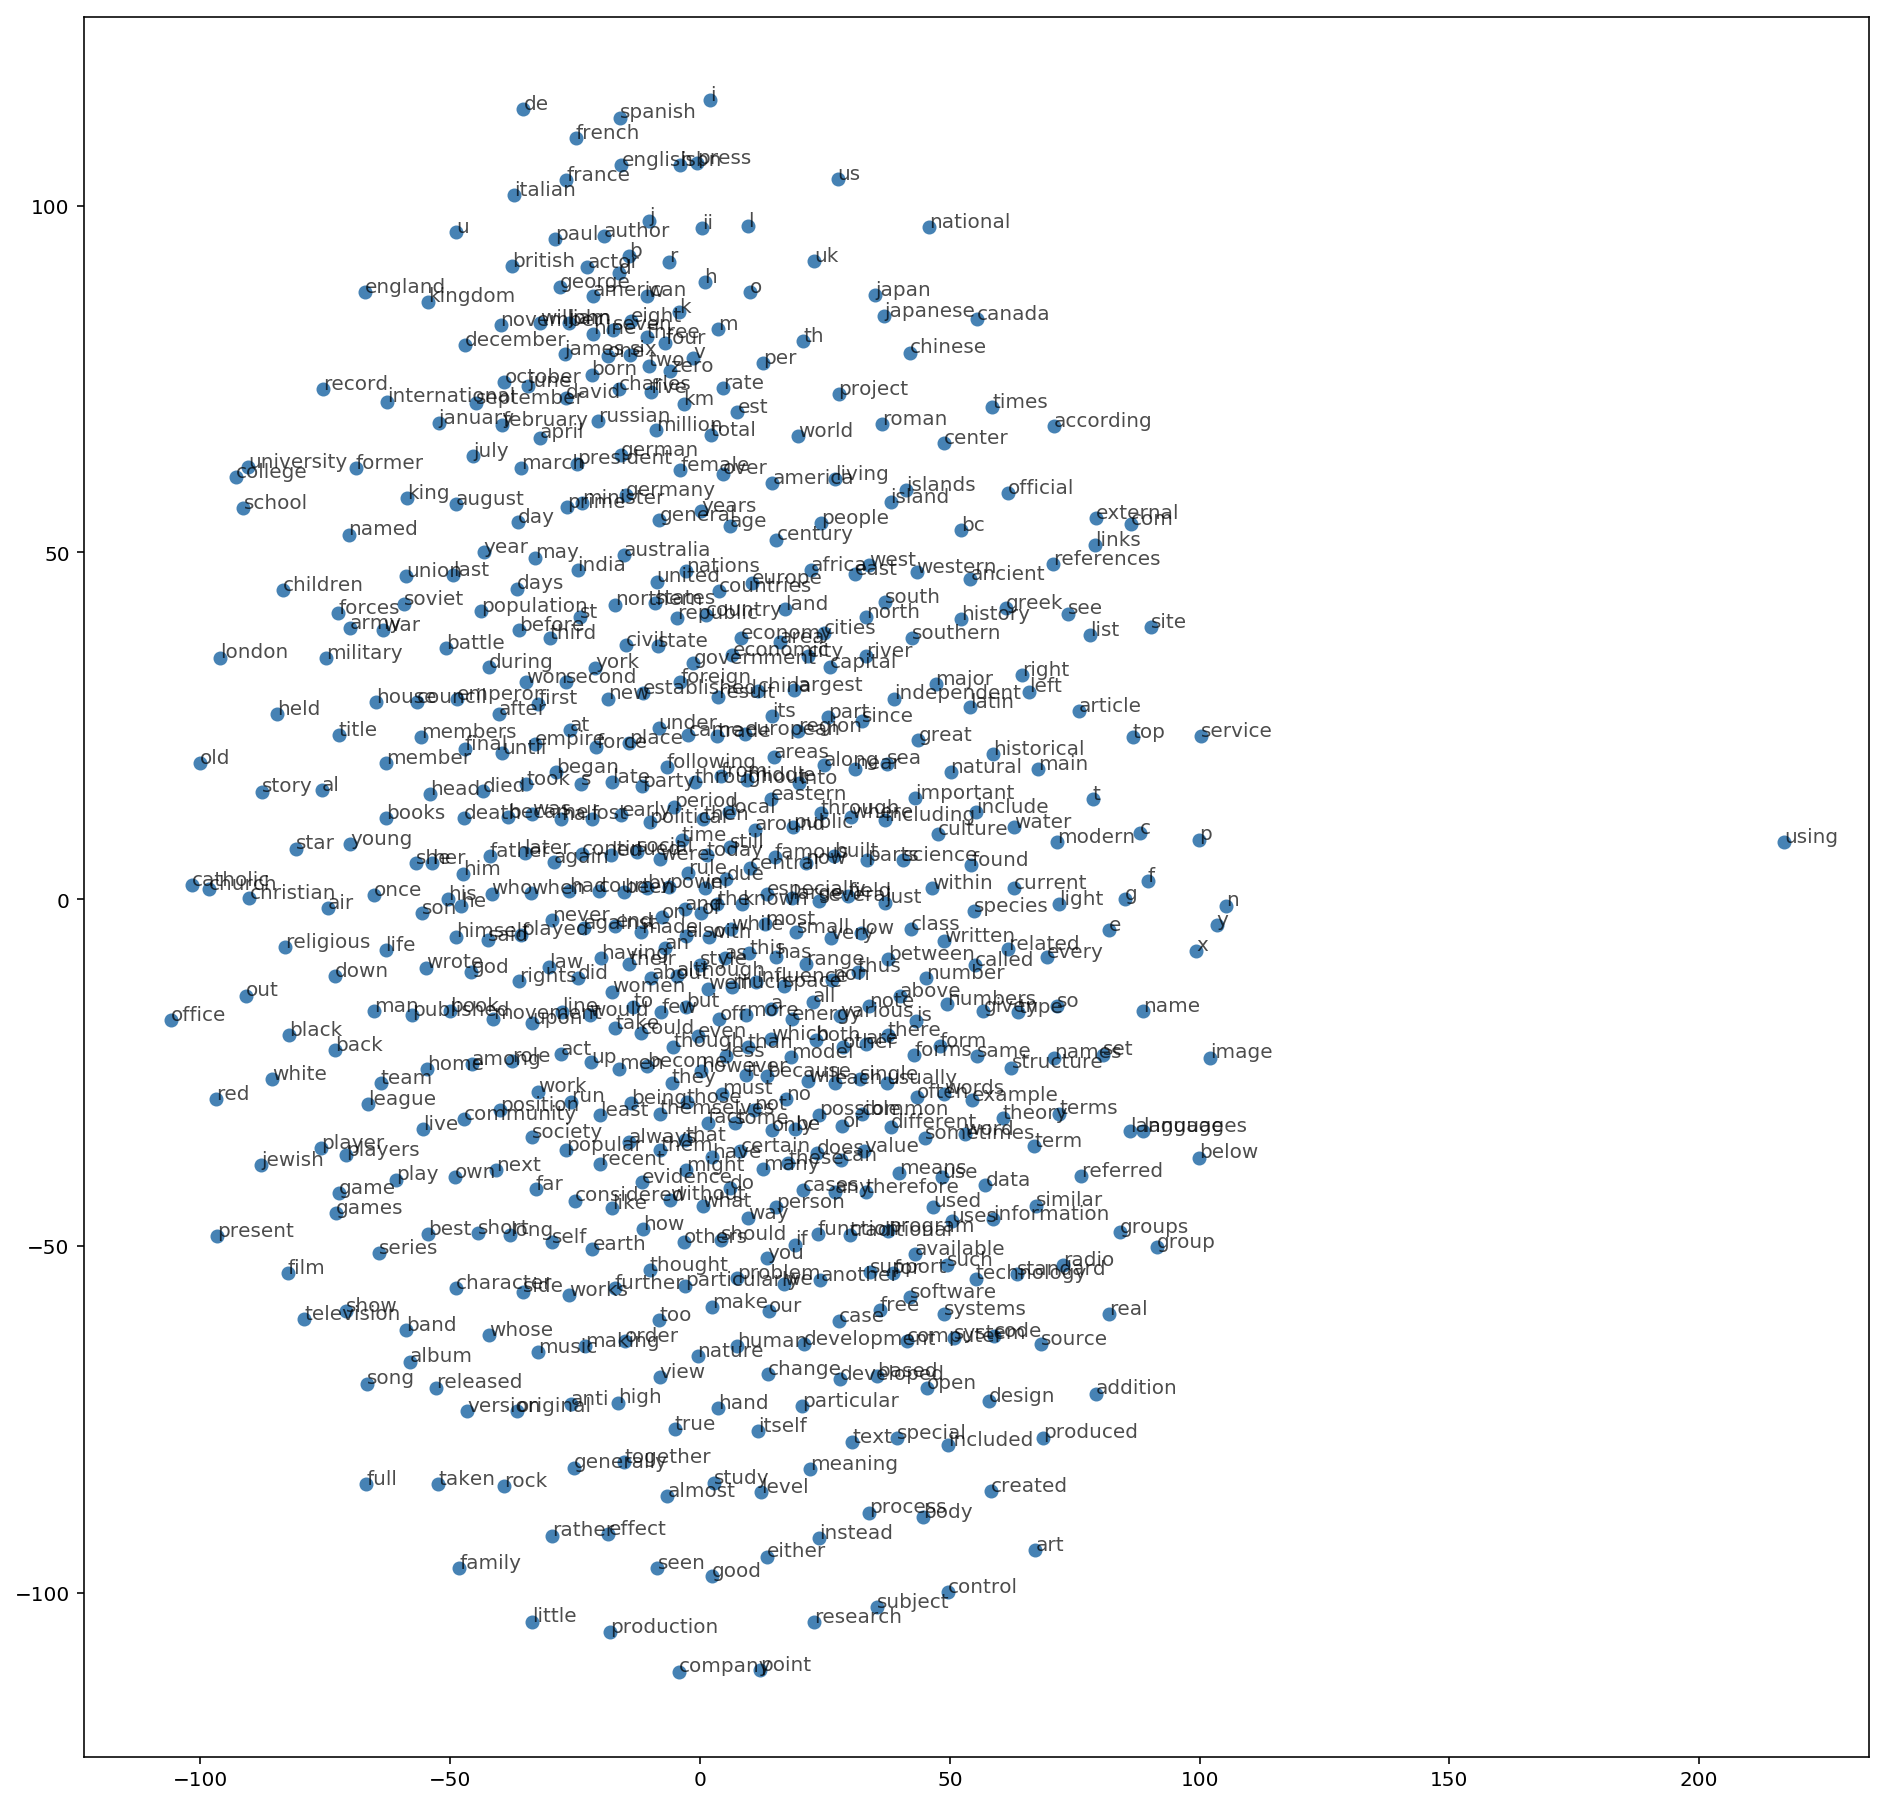

In [27]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)